# Evaluating Your Forecast

So far you have prepared your data, and generated your first Forecast. Now is the time to pull down the predictions from this Predictor, and compare them to the actual observed values. This will let us know the impact of accuracy based on the Forecast.

You can extend the approaches here to compare multiple models or predictors and to determine the impact of improved accuracy on your use case.

Overview:

* Setup
* Obtaining a Prediction
* Plotting the Actual Results
* Plotting the Prediction
* Comparing the Prediction to Actual Results

## Setup

In [126]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

Import the standard Python Libraries that are used in this lesson.

In [127]:
import json
import time
import dateutil.parser

import boto3
import pandas as pd

The line below will retrieve your shared variables from the earlier notebooks.

In [128]:
%store -r

Once again connect to the Forecast APIs via the SDK.

In [129]:
import sagemaker
import boto3

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = boto3.Session().region_name

session = boto3.Session(region_name=region) 
forecast = session.client(service_name='forecast') 
forecastquery = session.client(service_name='forecastquery')

In [130]:
%store -r forecast_arn
%store -r forecast_predictor_arn

## Obtaining a Prediction:

Now that your predictor is active we will query it to get a prediction that will be plotted later.

In [131]:
forecastResponse = forecastquery.query_forecast(
    ForecastArn=forecast_arn,
    Filters={"item_id":"client_12"}
)

## Plotting the Actual Results

In the first notebook we created a file of observed values, we are now going to select a given date and customer from that dataframe and are going to plot the actual usage data for that customer. 

In [132]:
actual_df = pd.read_csv("data/item-demand-time-validation.csv", names=['timestamp','value','item'])
actual_df.head()

,timestamp,value,item
0,2014-10-31 00:00:00,62.396352,client_12
1,2014-10-31 01:00:00,59.286899,client_12
2,2014-10-31 02:00:00,49.129353,client_12
3,2014-10-31 03:00:00,55.555556,client_12
4,2014-10-31 04:00:00,50.580431,client_12


Next we need to reduce the data to just the day we wish to plot, which is the First of November 2014.

In [133]:
actual_df = actual_df[(actual_df['timestamp'] >= '2014-10-31') & (actual_df['timestamp'] < '2014-11-01')]

Lastly, only grab the items for client_12

In [134]:
actual_df = actual_df[(actual_df['item'] == 'client_12')]
actual_df.head()

,timestamp,value,item
0,2014-10-31 00:00:00,62.396352,client_12
1,2014-10-31 01:00:00,59.286899,client_12
2,2014-10-31 02:00:00,49.129353,client_12
3,2014-10-31 03:00:00,55.555556,client_12
4,2014-10-31 04:00:00,50.580431,client_12


<Axes: >

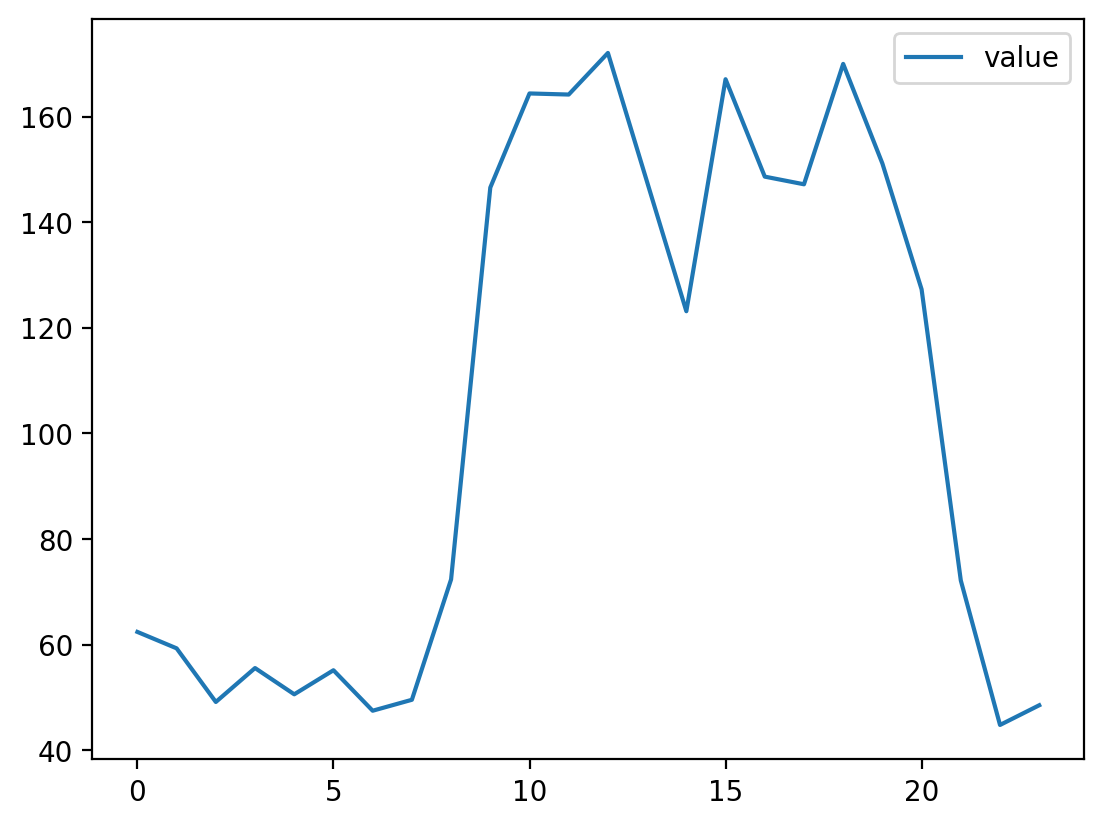

In [135]:
actual_df.plot()

## Plotting the Prediction:

Next we need to convert the JSON response from the Predictor to a dataframe that we can plot.

In [136]:
# Generate DF 
prediction_df_p10 = pd.DataFrame.from_dict(forecastResponse['Forecast']['Predictions']['p10'])
prediction_df_p10.head()

,Timestamp,Value
0,2014-10-31T00:00:00,46.648842
1,2014-10-31T01:00:00,44.050598
2,2014-10-31T02:00:00,43.306332
3,2014-10-31T03:00:00,34.521053
4,2014-10-31T04:00:00,32.329380


<Axes: >

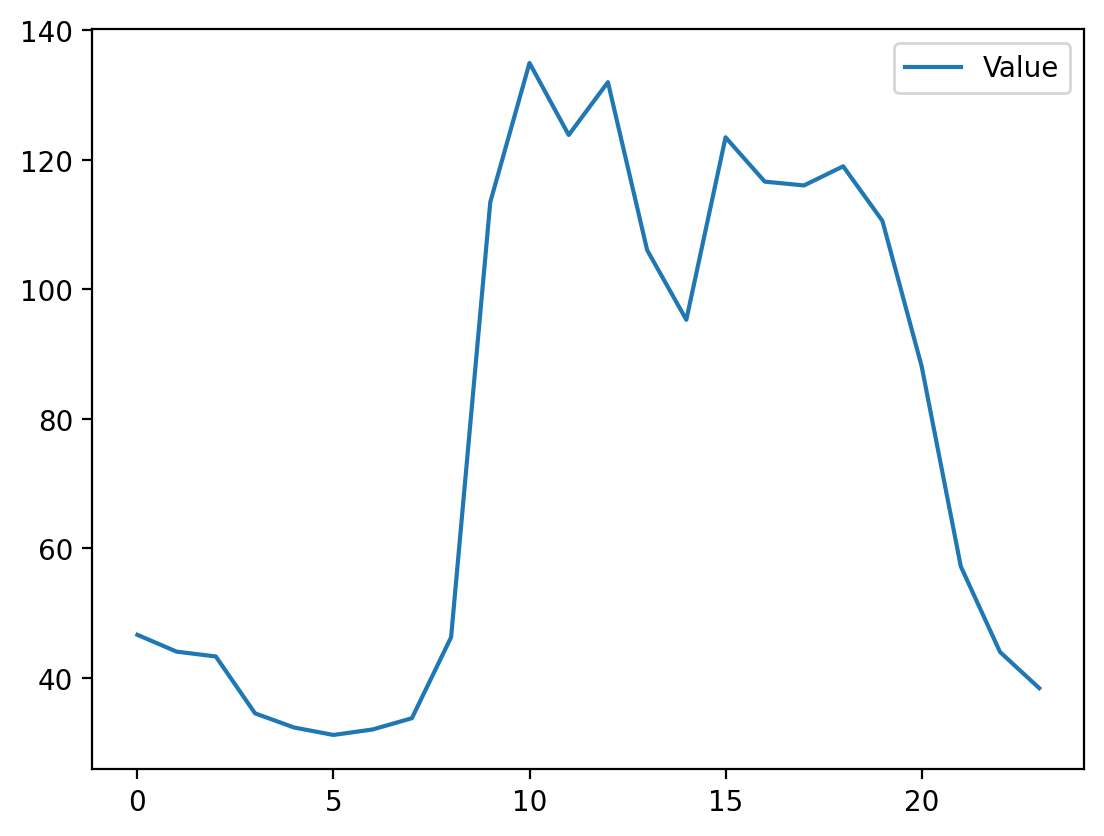

In [137]:
# Plot
prediction_df_p10.plot()

The above merely did the p10 values, now do the same for p50 and p90.

In [138]:
prediction_df_p50 = pd.DataFrame.from_dict(forecastResponse['Forecast']['Predictions']['p50'])
prediction_df_p90 = pd.DataFrame.from_dict(forecastResponse['Forecast']['Predictions']['p90'])

## Comparing the Prediction to Actual Results

After obtaining the dataframes the next task is to plot them together to determine the best fit.

In [139]:
# We start by creating a dataframe to house our content, here source will be which dataframe it came from
results_df = pd.DataFrame(columns=['timestamp', 'value', 'source'])
results_df['value'] = actual_df['value']
results_df['source'] = 'actual'

Import the observed values into the dataframe:

In [140]:
import numpy as np
actual_df['clean_timestamp'] = np.nan
for index, row in actual_df.iterrows():
    actual_df['clean_timestamp'] = dateutil.parser.parse(row['timestamp'])
results_df['timestamp'] = actual_df['clean_timestamp']

In [148]:
results_df.head()

,timestamp,value,source
0,2014-10-31 23:00:00,62.396352,actual
1,2014-10-31 23:00:00,59.286899,actual
2,2014-10-31 23:00:00,49.129353,actual
3,2014-10-31 23:00:00,55.555556,actual
4,2014-10-31 23:00:00,50.580431,actual


In [142]:
# for index, row in actual_df.iterrows():
#     clean_timestamp = dateutil.parser.parse(row['timestamp'])
#     temp = pd.Series(data = [clean_timestamp, row['value'], 'actual'])
#     results_df = pd.concat([results_df, temp], axis = 0, ignore_index=True)

In [149]:
def evaluation_df(result, target, source):
    temp = pd.DataFrame(columns=['timestamp', 'value', 'source'])
    for index, row in target.iterrows():
        target['clean_timestamp'] = dateutil.parser.parse(row['Timestamp'])
    temp['timestamp'] = target['clean_timestamp']
    temp['value'] = target['Value']
    temp['source'] = source
    result = pd.concat([result, temp], axis = 0)
    return result

In [157]:
# Now add the P10, P50, and P90 Values
results_df = evaluation_df(results_df, prediction_df_p10, 'p10')
results_df = evaluation_df(results_df, prediction_df_p50, 'p50')
results_df = evaluation_df(results_df, prediction_df_p90, 'p90')
# for index, row in prediction_df_p10.iterrows():
#     clean_timestamp = dateutil.parser.parse(row['Timestamp'])
#     results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p10'} , ignore_index=True)
# for index, row in prediction_df_p50.iterrows():
#     clean_timestamp = dateutil.parser.parse(row['Timestamp'])
#     results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p50'} , ignore_index=True)
# for index, row in prediction_df_p90.iterrows():
#     clean_timestamp = dateutil.parser.parse(row['Timestamp'])
#     results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p90'} , ignore_index=True)

In [158]:
results_df['source'].nunique()

4

In [159]:
pivot_df = results_df.pivot(columns='source', values='value', index="timestamp")
pivot_df

ValueError: Index contains duplicate entries, cannot reshape

In [147]:
pivot_df.plot()

NameError: name 'pivot_df' is not defined

Once you are done exploring this Forecast you can cleanup all the work that was done by executing the cells inside `Cleanup.ipynb` within this folder.